In [188]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

#https://www.kaggle.com/competitions/dont-overfit-ii/

## githun link: 
https://github.com/carsonxie/Machine-Learning-Projects/tree/main/c2%20Unsupervised%20Learning%20method


In [189]:
train_df = pd.read_csv("train2.csv")
# #test_df = pd.read_csv("../input/test.csv")
print("Train shape : ", train_df.shape)

Train shape :  (250, 302)


# Notebook outline:

### 1. data cleaning
the data is clean, but label are inbalance, over sampleing method need to be used.
### 2. EDA
### 3. Apply dimension reduction
choose k
### 4. Build unsupervised learning model
Kmeans and AgglomerativeClustering
### 5. Build supervised learning model and compare result.
random forest and logistic regression.

In [190]:
train_df.drop(['id'],axis=1,inplace=True)
train_df.head()

,target,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,-0.443,...,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,0.557,...,-0.765,-0.735,-1.158,2.554,0.856,-1.506,0.462,-0.029,-1.932,-0.343
2,0.0,0.099,1.390,-0.732,-1.065,0.005,-0.081,-1.450,0.317,-0.624,...,-1.311,0.799,-1.001,1.544,0.575,-0.309,-0.339,-0.148,-0.646,0.725
3,1.0,-0.989,-0.916,-1.343,0.145,0.543,0.636,1.127,0.189,-0.118,...,-1.370,1.093,0.596,-0.589,-0.649,-0.163,-0.958,-1.081,0.805,3.401
4,0.0,0.811,-1.509,0.522,-0.360,-0.220,-0.959,0.334,-0.566,-0.656,...,-0.178,0.718,-1.017,1.249,-0.596,-0.445,1.751,1.442,-0.393,-0.643


## EDA

0.0    183
1.0     67
Name: target, dtype: int64
Class 0 are 173.0 % more than class 1


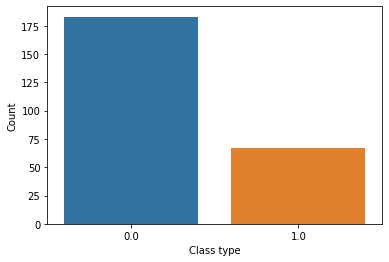

In [41]:
count = train_df.target.value_counts()
sns.barplot(x=count.index, y=count)
print(count)
plt.ylabel("Count")
plt.xlabel("Class type")
print('Class 0 are', 100*round((count[0]-count[1])/count[1],2), '% more than class 1')

Mean value of all features, somehow normal

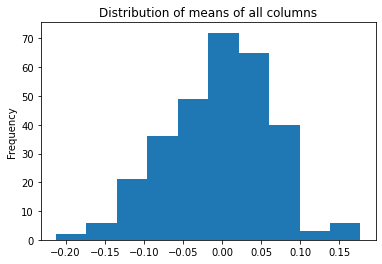

In [43]:
train_df[train_df.columns[2:]].mean().plot(kind='hist')
plt.title('Distribution of means of all columns')

Correlation plot

<AxesSubplot:>

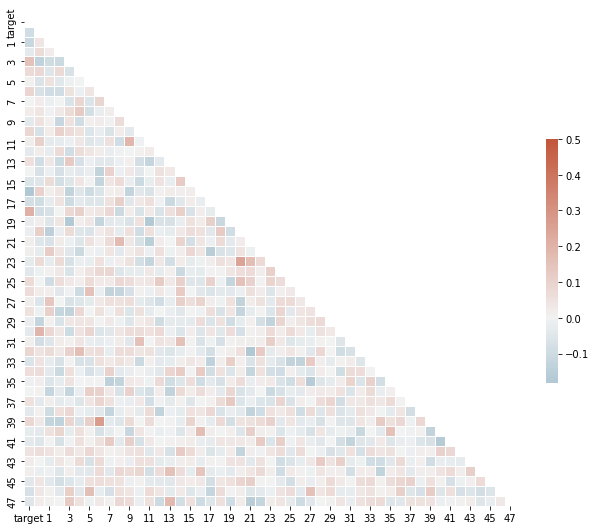

In [67]:
first = train_df.iloc[:,1:50]
corr = first.corr()

#mask for upper triangle in plot
mask = np.triu(np.ones_like(corr, dtype=bool))


f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.5, center=0,
            linewidths=.5,cbar_kws={"shrink": .5})

Plot top 20 strongest corr features 

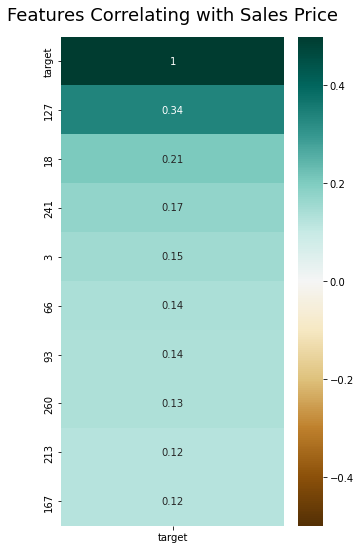

In [85]:
plt.figure(figsize=(5, 9))
heatmap = sns.heatmap(train_df.corr()[['target']].sort_values(by='target', ascending=False)[:10], 
                      vmin=-0.5, vmax=0.5, annot=True, cmap='BrBG')

heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

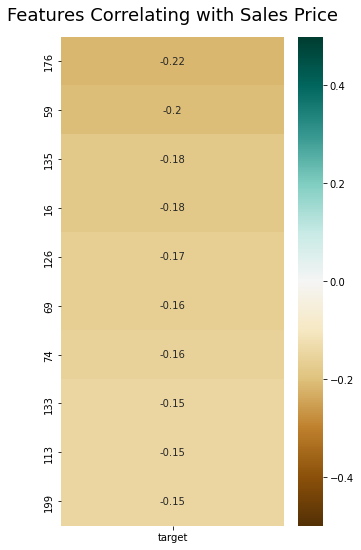

In [84]:
# top negative corrlatino
plt.figure(figsize=(5, 9))
heatmap = sns.heatmap(train_df.corr()[['target']].sort_values(by='target', ascending=True)[:10], 
                      vmin=-0.5, vmax=0.5, annot=True, cmap='BrBG')

heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

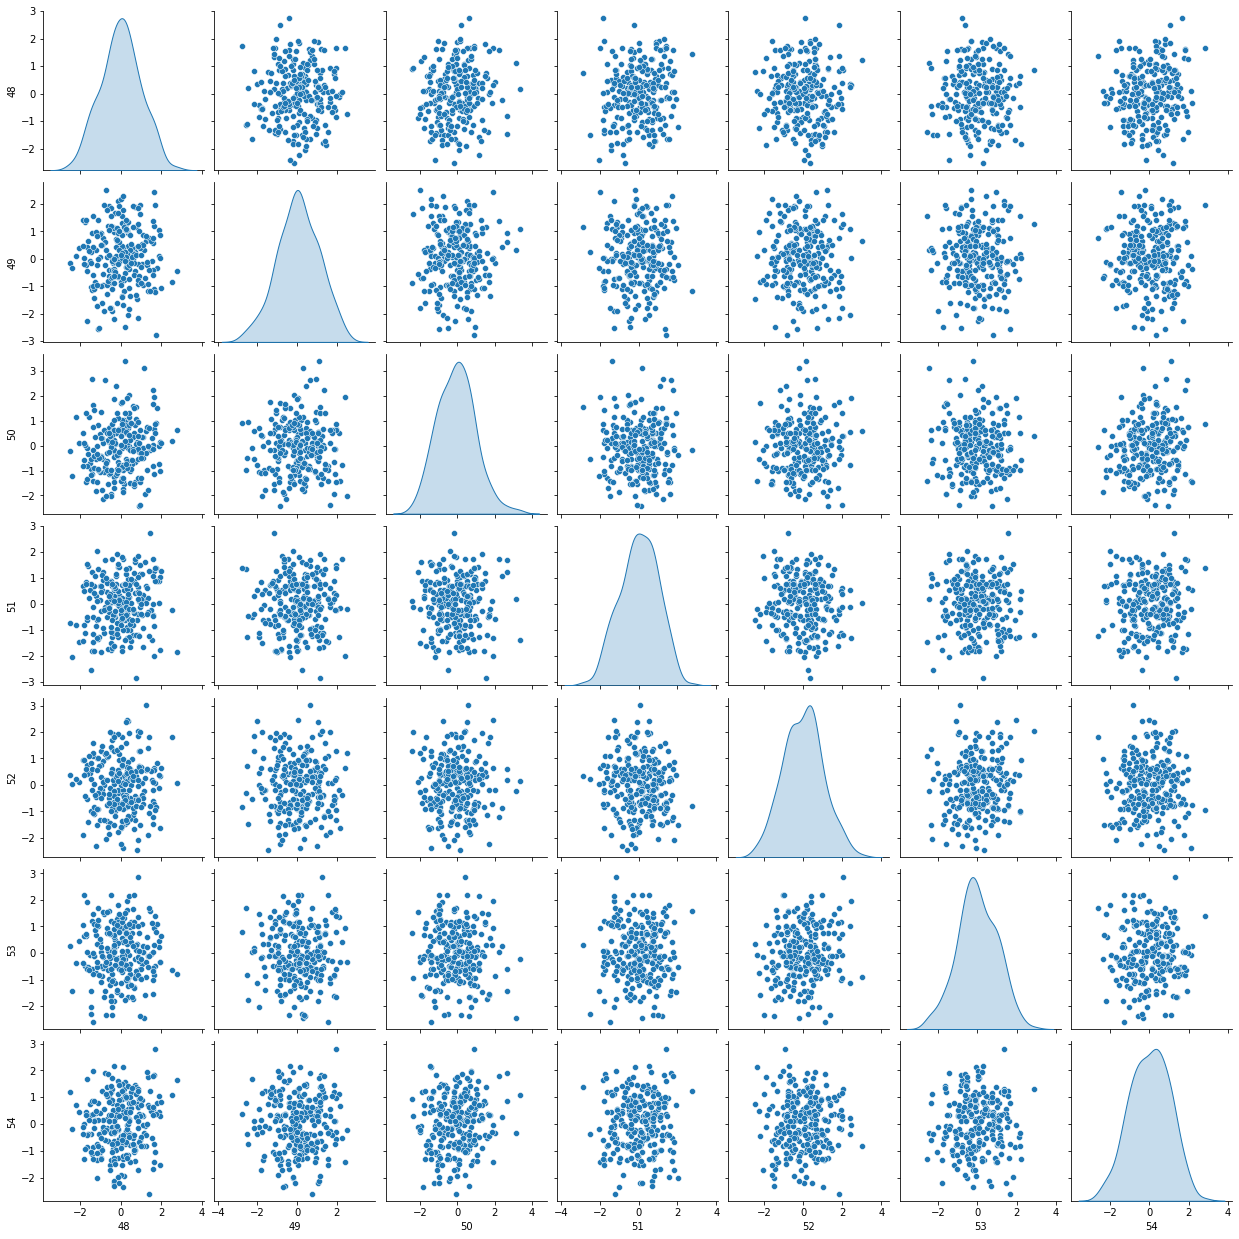

In [93]:
sns.pairplot(train_df.iloc[:,50:57], diag_kind='kde')
plt.show()

## PCA 

In [191]:
from sklearn.decomposition import PCA

pca = PCA(n_components=250)
X_reduced = pca.fit_transform(train_df.drop(['target'],axis=1))

#pca.explained_variance_ratio_
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.9) + 1
d

139

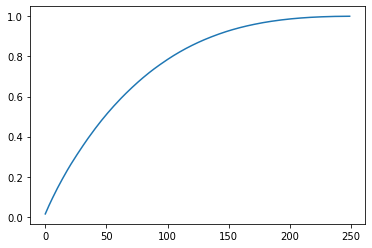

In [192]:
xx = range(cumsum.shape[0])
plt.plot(xx, cumsum)

plt.show()

In [206]:
# reduce to 139 features
pca = PCA(n_components=139)
X_reduced = pca.fit_transform(train_df.drop(['target'],axis=1))
train_pca = pd.DataFrame(X_reduced)
print(train_pca.shape)

(250, 139)


## Build unsupervised learning model on both dataset

In [207]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    train_df.drop(['target'],axis=1), train_df.target, 
    test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
train = train_df.drop(['target'],axis=1)

#pca data
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    train_pca, train_df.target, 
    test_size=0.2, random_state=42)

print(X_train_p.shape)
print(X_test_p.shape)

(200, 300)
(50, 300)
(200, 139)
(50, 139)


In [208]:
for i in range(1, 130):
    train_pca[i+600] = train.iloc[:,i-1]
    


C:\Users\carso\AppData\Local\Temp/ipykernel_24048/4016078246.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  train_pca[i+600] = train.iloc[:,i-1]


In [209]:
train_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,720,721,722,723,724,725,726,727,728,729
0,0.828771,-3.107156,0.138134,-0.667622,1.344234,2.255178,-1.793096,0.636150,-0.039398,0.550204,...,0.885,0.044,-1.131,-1.576,0.616,1.957,-0.518,1.494,1.573,-0.484
1,-1.705791,-0.581743,0.185615,5.672489,1.544129,1.578285,-2.086984,-0.060767,-1.508625,-2.094737,...,1.883,-0.292,-0.849,-0.453,0.894,0.339,2.095,0.336,1.290,0.057
2,-0.798465,-0.768648,-0.256305,-1.618627,-0.922349,-1.859134,0.088064,1.896174,0.991520,-1.680238,...,-0.645,0.331,0.052,-0.323,-1.327,-0.546,0.799,0.649,0.016,-0.723
3,2.461253,-0.200618,0.867868,-0.429795,0.547376,4.457454,0.600880,0.104095,-2.332072,1.948321,...,1.241,0.168,0.717,1.854,0.793,0.067,-1.493,-0.723,0.816,1.035
4,-3.015808,3.133484,-3.590135,-0.129154,-3.225399,-2.581781,-1.000008,-3.301716,1.102771,0.885133,...,-0.897,0.657,-1.072,1.149,0.045,1.159,-0.439,-0.763,-0.815,-1.277


k means

In [210]:
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score

kmeans = KMeans(n_clusters=2, random_state=0)

cv1 = cross_val_score(kmeans, X=train, y=train_df.target, 
                      scoring='rand_score', cv=5)

cv2 = cross_val_score(kmeans, X=train_pca, y=train_df.target, 
                      scoring='rand_score', cv=5)

print(f'mean score before PCA: {np.mean(cv1)}, std:{np.std(cv1)}')
print(f'mean score after PCA: {np.mean(cv2)}, std:{np.std(cv2)}')

mean score before PCA: 0.49387755102040815, std:0.00467520687780454
mean score after PCA: 0.49518367346938774, std:0.0044890537419975795


In [211]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import rand_score
from sklearn.metrics import accuracy_score

clustering = AgglomerativeClustering(n_clusters=2)

clustering = AgglomerativeClustering().fit(train)
print(rand_score(clustering.labels_ ,train_df.target))

clustering2 = AgglomerativeClustering().fit(train_pca)
print(rand_score(clustering2.labels_ ,train_df.target))

0.49812048192771086
0.503421686746988


## Build supervised learning model and compare result.

In [212]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l1',solver='liblinear',C=0.2)

cv1 = cross_val_score(model, X=train, y=train_df.target, 
                      scoring='accuracy', cv=5)

cv2 = cross_val_score(model, X=train_pca, y=train_df.target, 
                      scoring='accuracy', cv=5)

cv3 = cross_val_score(model, X=train, y=train_df.target, 
                      scoring='rand_score', cv=5)

print(f'mean score before PCA: {round(np.mean(cv1),4)}, std: {round(np.std(cv1),4)}')
print(f'mean score after PCA: {round(np.mean(cv2),4)}, std: {round(np.std(cv2),4)}')
print(f'rand score for comparsion: {round(np.mean(cv3),4)}, std: {round(np.std(cv3),4)}')

mean score before PCA: 0.76, std: 0.0551
mean score after PCA: 0.7, std: 0.0219
rand score for comparsion: 0.634, std: 0.0584


In [213]:
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(max_depth=3)

cv1 = cross_val_score(model, X=train, y=train_df.target, 
                      scoring='accuracy', cv=5)

cv2 = cross_val_score(model, X=train_pca, y=train_df.target, 
                      scoring='accuracy', cv=5)

print(f'mean score before PCA: {round(np.mean(cv1),4)}, std: {round(np.std(cv1),4)}')
print(f'mean score after PCA: {round(np.mean(cv2),4)}, std: {round(np.std(cv2),4)}')

mean score before PCA: 0.732, std: 0.0098
mean score after PCA: 0.732, std: 0.0098


### Result analysis: 

1. To find the k-value, we set explained  variance to a large value(250) and find the 'elow' point is around 130, so k=139 is choosen with 95% explained variance.

2. For KMeans model, it report 0.495 rand score on testset, and PCA has slightly improve the score.

3. For LogisticRegression and RandomForestClassifier, PCA decrease the score on logistic regression, and performe the same in random forest.

## Conclusion:
1. Takeaways: In this dataset, PCA can help increase score on kmeans algorithm
2. Thing that did not work: PCA on supervised method has no improvement.
3. Future improvement: Try different dataset to find out what type of dataset that PCA can improve supervised model score.